[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jrahu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Error fetching tweets: 403 Forbidden
453 - You currently have access to a subset of Twitter API v2 endpoints and limited v1.1 endpoints (e.g. media post, oauth) only. If you need access to this endpoint, you may need a different access level. You can learn more here: https://developer.twitter.com/en/portal/product


C:\Users\jrahu\AppData\Local\Temp\ipykernel_27024\4107472150.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='coolwarm')


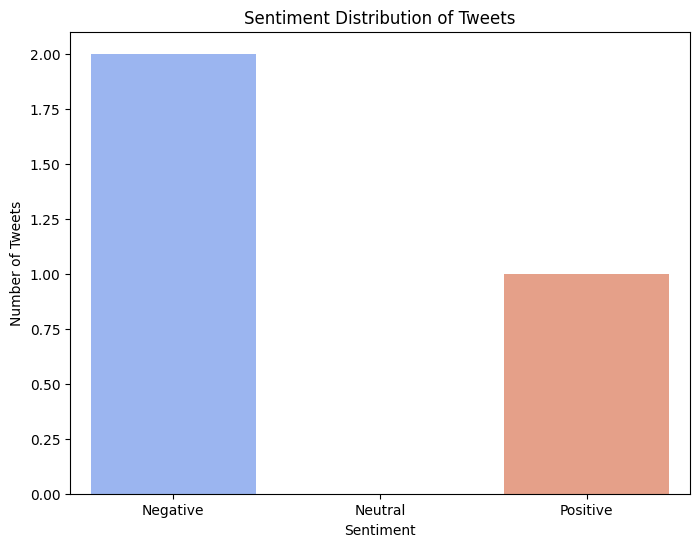

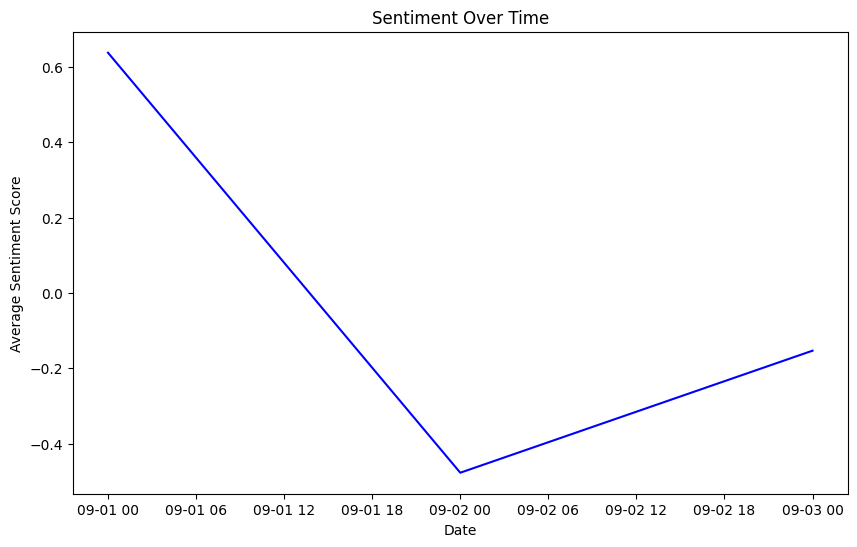

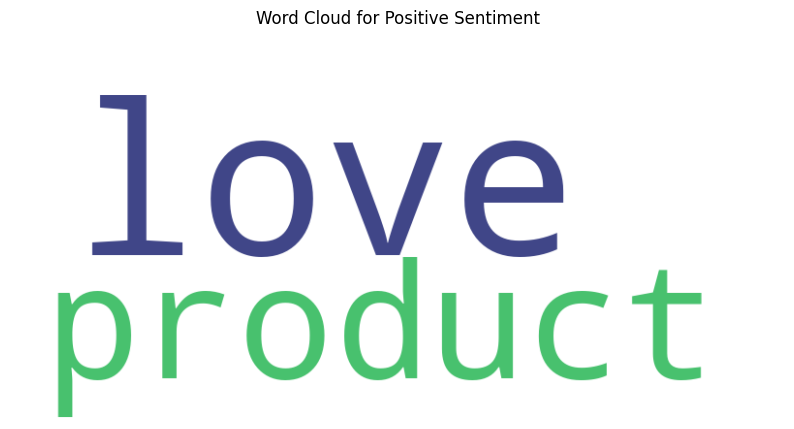

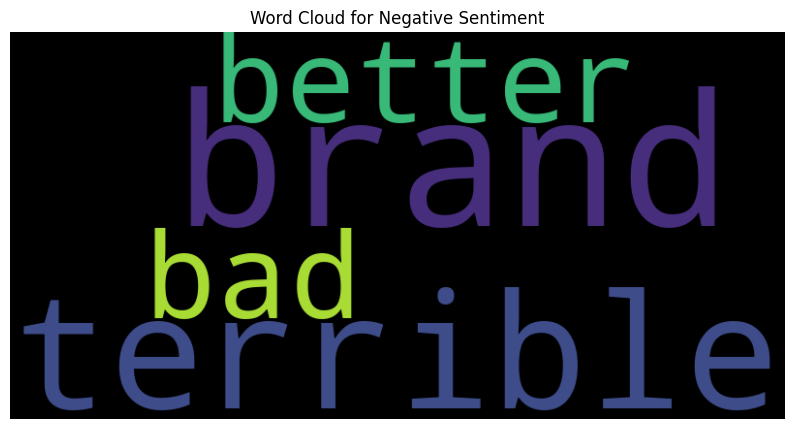

In [7]:
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords for cleaning process
nltk.download('stopwords')

# Step 1: Twitter API Authentication (Replace with your own keys)
consumer_key = 'U6PaYczaSTIFFvtr5lpneCwB8'
consumer_secret = 'pbv5tSOUuJv2m4dwSV9KLyaM1GlI8wu6DUbUubOAIp0szFMXDQ'
access_token = '1835052560098508800-1ufJUHjjSU6Ct6tcHFHBzNjV1qE95C'
access_token_secret = 'vVH75rN1GsdJ3jHcWM55Padi4U6hBxFlqgcy8nIGDfxgi'

# Authenticate with the Twitter API
auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

# Function to fetch tweets based on a query
def fetch_tweets(query, count=100):
    try:
        tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", tweet_mode='extended').items(count)
        tweet_list = [[tweet.full_text, tweet.created_at] for tweet in tweets]
        return pd.DataFrame(tweet_list, columns=['text', 'created_at'])
    except Exception as e:
        print("Error fetching tweets:", e)
        # Return simulated data for testing purposes if API fails
        data = {'text': ['I love this product!', 'This brand is terrible.', 'Not too bad, could be better.'],
                'created_at': pd.date_range(start='2023-09-01', periods=3, freq='D')}
        return pd.DataFrame(data)

# Fetch tweets (or simulated data) about a topic or brand (e.g., "Tesla")
df = fetch_tweets(query="Tesla", count=100)

# Step 2: Data Preprocessing
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Step 3: Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  # Get compound score (-1 to 1 scale)

# Apply sentiment analysis to the cleaned tweets
df['sentiment'] = df['cleaned_text'].apply(analyze_sentiment)

# Classify sentiment as Positive, Neutral, or Negative
df['sentiment_label'] = pd.cut(df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

# Step 4: Visualize Sentiment Distribution (Bar Chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, palette='coolwarm')
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# Step 5: Visualize Sentiment Over Time (Line Chart)
# Convert the 'created_at' column to datetime format for time-based analysis
df['created_at'] = pd.to_datetime(df['created_at'])

# Resample by day and calculate the mean sentiment score per day
df['created_at'] = pd.to_datetime(df['created_at'])  # Ensure 'created_at' is in datetime format
df_time = df.resample('D', on='created_at')['sentiment'].mean()  # Resample only the 'sentiment' column

# Plot sentiment over time
plt.figure(figsize=(10, 6))
plt.plot(df_time.index, df_time, color='blue')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()
# Step 6: Generate Word Clouds for Positive and Negative Sentiments
# Word cloud for positive sentiment
positive_text = ' '.join(df[df['sentiment_label'] == 'Positive']['cleaned_text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# Word cloud for negative sentiment
negative_text = ' '.join(df[df['sentiment_label'] == 'Negative']['cleaned_text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()